# Red Neuronal Multicapa (MLP) con PyTorch

**Materiales desarrollados por Matías Barreto, 2025**

**Tecnicatura en Ciencia de Datos - IFTS**

**Asignatura:** Procesamiento de Lenguaje Natural

---

## Introducción

En el notebook anterior implementamos un perceptrón simple desde cero y descubrimos sus limitaciones: solo puede resolver problemas linealmente separables. Ahora damos el salto hacia las **redes neuronales multicapa** (MLP - Multilayer Perceptron), que superan estas restricciones.

Además, dejaremos de programar todo manualmente y usaremos **PyTorch**, el framework de deep learning más usado en investigación y cada vez más en la industria. PyTorch es la base de HuggingFace Transformers, que usaremos en las próximas semanas.

### ¿Qué cambia con capas ocultas?

Agregar capas intermedias entre entrada y salida permite:
1. **Resolver problemas no lineales** (como XOR)
2. **Aprender representaciones jerárquicas** (features abstractas)
3. **Capturar interacciones complejas** entre palabras
4. **Aproximar funciones arbitrarias** (teorema de aproximación universal)

### Objetivos de aprendizaje

1. Comprender la arquitectura de redes feedforward multicapa
2. Dominar los fundamentos de PyTorch: tensores, autograd, nn.Module
3. Implementar una red MLP para clasificación de texto
4. Usar funciones de activación modernas (ReLU, Sigmoid)
5. Entrenar con backpropagation automática
6. Comparar rendimiento con el perceptrón simple

### ¿Por qué PyTorch?

**Ventajas:**
- Autograd: Calcula gradientes automáticamente
- Sintaxis pythónica e intuitiva
- Debugging fácil (ejecución eager)
- Ecosistema rico (HuggingFace, torchvision, etc.)
- GPU acceleration out-of-the-box
- Estándar en investigación académica

---

## 1. Instalación e Importación de PyTorch

En Google Colab, PyTorch ya viene instalado. Para instalación local, visitar: https://pytorch.org

In [1]:
# Si necesitás instalar PyTorch (descomentá la línea siguiente)
# !pip install torch

# PyTorch: Framework de deep learning
import torch
# torch.nn: Módulo con capas y modelos de redes neuronales
import torch.nn as nn
# torch.optim: Optimizadores (SGD, Adam, etc.)
import torch.optim as optim

# NumPy: Para operaciones numéricas complementarias
import numpy as np

# Matplotlib: Para visualizaciones
import matplotlib.pyplot as plt

# Fijamos semillas para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch versión: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Ejecutando en CPU (suficiente para este notebook)")

PyTorch versión: 2.8.0+cu126
CUDA disponible: True
GPU: Tesla T4


---

## 2. Dataset: Análisis de Sentimiento en Español Rioplatense

Usamos un corpus más grande que en el perceptrón simple para aprovechar la capacidad de la red multicapa.

In [2]:
# Corpus ampliado de reseñas en español rioplatense
# Etiqueta: 1 = Positivo, 0 = Negativo
frases = [
    # Positivas
    "La verdad, este lugar está bárbaro. Muy recomendable.",
    "Qué buena onda la atención, volvería sin dudarlo.",
    "Me encantó la comida, aunque la música estaba muy fuerte.",
    "Todo excelente. Atención de diez.",
    "Muy conforme con el resultado final.",
    "Superó mis expectativas, gracias.",
    "El mejor asado que probé en mucho tiempo.",
    "Excelente relación precio-calidad, muy recomendable.",
    "La atención fue impecable, muy atentos.",
    "Me gustó mucho el ambiente tranquilo.",

    # Negativas
    "Una porquería de servicio, nunca más vuelvo.",
    "El envío fue lento y el producto llegó dañado. Qué desastre.",
    "Qué estafa, me arrepiento de haber comprado.",
    "No me gustó para nada la experiencia.",
    "No lo recomiendo, mala calidad.",
    "Malísima atención, el mozo tenía mala onda.",
    "Tardaron dos horas en entregar, llegó todo frío.",
    "Me cobraron de más y encima se hicieron los giles.",
    "La carne estaba pasada, casi no se podía comer.",
    "Pésima experiencia, no vuelvo más."
]

# Etiquetas: 1=positivo, 0=negativo
etiquetas = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # 10 positivas
                      0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # 10 negativas

print(f"Corpus de entrenamiento: {len(frases)} frases")
print(f"Distribución: {np.bincount(etiquetas)} (negativas, positivas)")
print(f"\nPrimeras 3 frases positivas:")
for i in range(3):
    print(f"  {i+1}. {frases[i]}")
print(f"\nPrimeras 3 frases negativas:")
for i in range(10, 13):
    print(f"  {i-9}. {frases[i]}")

Corpus de entrenamiento: 20 frases
Distribución: [10 10] (negativas, positivas)

Primeras 3 frases positivas:
  1. La verdad, este lugar está bárbaro. Muy recomendable.
  2. Qué buena onda la atención, volvería sin dudarlo.
  3. Me encantó la comida, aunque la música estaba muy fuerte.

Primeras 3 frases negativas:
  1. Una porquería de servicio, nunca más vuelvo.
  2. El envío fue lento y el producto llegó dañado. Qué desastre.
  3. Qué estafa, me arrepiento de haber comprado.


---

## 3. Vocabulario y Vectorización

Construimos un vocabulario extendido con palabras clave del corpus.

In [3]:
# Vocabulario manual con palabras discriminativas
vocabulario = [
    # Positivas
    "bárbaro", "recomendable", "buena", "onda", "encantó",
    "excelente", "conforme", "superó", "expectativas", "mejor",
    "impecable", "gustó", "tranquilo",

    # Negativas
    "porquería", "nunca", "desastre", "estafa", "arrepiento",
    "no", "mala", "malísima", "pésima", "tardaron",
    "frío", "pasada",

    # Neutras/contextuales
    "lugar", "atención", "comida", "servicio", "experiencia"
]

print(f"Vocabulario: {len(vocabulario)} palabras")
print(vocabulario)

Vocabulario: 30 palabras
['bárbaro', 'recomendable', 'buena', 'onda', 'encantó', 'excelente', 'conforme', 'superó', 'expectativas', 'mejor', 'impecable', 'gustó', 'tranquilo', 'porquería', 'nunca', 'desastre', 'estafa', 'arrepiento', 'no', 'mala', 'malísima', 'pésima', 'tardaron', 'frío', 'pasada', 'lugar', 'atención', 'comida', 'servicio', 'experiencia']


In [4]:
def vectorizar(frase, vocabulario):
    """
    Convierte una frase en vector binario según el vocabulario.

    Args:
        frase (str): Texto a vectorizar
        vocabulario (list): Lista de palabras clave

    Returns:
        np.array: Vector binario (1 si palabra presente, 0 si no)
    """
    tokens = frase.lower().split()
    return np.array([1 if palabra in tokens else 0 for palabra in vocabulario], dtype=np.float32)


# Vectorizamos todas las frases
X_np = np.array([vectorizar(frase, vocabulario) for frase in frases], dtype=np.float32)
y_np = etiquetas.astype(np.float32).reshape(-1, 1)  # Shape (n, 1) para BCELoss

print(f"\nMatriz de características:")
print(f"Forma X: {X_np.shape} (muestras x features)")
print(f"Forma y: {y_np.shape}")
print(f"\nPrimera frase vectorizada:")
print(f"Frase: '{frases[0]}'")
print(f"Vector: {X_np[0]}")
palabras_presentes = [vocabulario[i] for i in range(len(vocabulario)) if X_np[0][i] == 1]
print(f"Palabras detectadas: {palabras_presentes}")


Matriz de características:
Forma X: (20, 30) (muestras x features)
Forma y: (20, 1)

Primera frase vectorizada:
Frase: 'La verdad, este lugar está bárbaro. Muy recomendable.'
Vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0.]
Palabras detectadas: ['lugar']


---

## 4. Introducción a Tensores en PyTorch

Los **tensores** son el equivalente de NumPy arrays en PyTorch, pero con capacidades adicionales:
- Pueden ejecutarse en GPU
- Registran operaciones para backpropagation automática (autograd)
- Integración nativa con redes neuronales

In [5]:
# Convertimos NumPy arrays a tensores de PyTorch
# torch.tensor() crea un nuevo tensor copiando los datos
X = torch.tensor(X_np)
y = torch.tensor(y_np)

print("Información de los tensores:")
print("=" * 70)
print(f"X.shape: {X.shape}")
print(f"X.dtype: {X.dtype}")
print(f"X.device: {X.device}  # cpu o cuda")
print(f"X.requires_grad: {X.requires_grad}  # False porque son datos, no parámetros")
print()
print(f"y.shape: {y.shape}")
print(f"y.dtype: {y.dtype}")

print("\n" + "=" * 70)
print("Operaciones con tensores:")
print("-" * 70)

# Operaciones básicas (similares a NumPy)
print(f"Media de X: {X.mean().item():.4f}")
print(f"Desviación estándar de X: {X.std().item():.4f}")
print(f"Suma de y: {y.sum().item():.0f}")

# .item() extrae el valor de un tensor de un solo elemento

Información de los tensores:
X.shape: torch.Size([20, 30])
X.dtype: torch.float32
X.device: cpu  # cpu o cuda
X.requires_grad: False  # False porque son datos, no parámetros

y.shape: torch.Size([20, 1])
y.dtype: torch.float32

Operaciones con tensores:
----------------------------------------------------------------------
Media de X: 0.0400
Desviación estándar de X: 0.1961
Suma de y: 10


---

## 5. Arquitectura de una Red Multicapa (MLP)

Una red feedforward multicapa consta de:

```
INPUT → [CAPA OCULTA 1] → [CAPA OCULTA 2] → ... → OUTPUT
```

### Arquitectura que vamos a implementar:

```
Input Layer          Hidden Layer        Output Layer
(30 features)        (8 neuronas)        (1 neurona)

x₁ ─┐
x₂ ─┤               h₁ ─┐
x₃ ─┤──────────────>h₂ ─┤
... │    ReLU        h₃ ─┤──────────────> y
x₃₀─┘               h₄ ─┤    Sigmoid
                    ... ─┘
                    h₈
```

### Componentes:

1. **Capa de entrada**: 30 features (tamaño del vocabulario)
2. **Capa oculta**: 8 neuronas con activación ReLU
3. **Capa de salida**: 1 neurona con activación Sigmoid (probabilidad 0-1)

### ¿Por qué ReLU?

**ReLU (Rectified Linear Unit):**
$$\text{ReLU}(x) = \max(0, x)$$

**Ventajas sobre escalón:**
- Diferenciable en casi todos lados (excepto x=0)
- No sufre vanishing gradient
- Computacionalmente eficiente
- Introduce no linealidad necesaria para problemas complejos

### ¿Por qué Sigmoid en la salida?

**Sigmoid:**
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

**Ventajas:**
- Salida en rango [0, 1]: interpretable como probabilidad
- Diferenciable en todos lados
- Compatible con Binary Cross Entropy Loss

---

## 6. Definición del Modelo con nn.Module

En PyTorch, todos los modelos heredan de `nn.Module`. Esto nos da:
- Gestión automática de parámetros
- Métodos para entrenamiento/evaluación
- Compatibilidad con optimizadores
- Serialización fácil (guardar/cargar modelo)

In [6]:
class MLP(nn.Module):
    """
    Perceptrón Multicapa para clasificación binaria de sentimientos.

    Arquitectura:
        Input (input_size) → Hidden (hidden_size) → Output (1)
                              ReLU                   Sigmoid
    """

    def __init__(self, input_size, hidden_size):
        """
        Constructor del modelo.

        Args:
            input_size (int): Número de features de entrada
            hidden_size (int): Número de neuronas en la capa oculta
        """
        # Llamamos al constructor de la clase padre (nn.Module)
        super(MLP, self).__init__()

        # Definimos las capas de la red usando nn.Sequential
        # Sequential encadena capas: la salida de una es entrada de la siguiente
        self.net = nn.Sequential(
            # Capa 1: Linear (fully connected) de input_size a hidden_size
            # Hace: y = Wx + b, donde W shape (hidden_size, input_size)
            nn.Linear(input_size, hidden_size),

            # Activación ReLU: max(0, x)
            # Introduce no linealidad, permite aprender patrones complejos
            nn.ReLU(),

            # Capa 2: Linear de hidden_size a 1 (salida)
            nn.Linear(hidden_size, 1),

            # Activación Sigmoid: 1 / (1 + e^-x)
            # Convierte salida a rango [0, 1] (probabilidad)
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass: define cómo los datos fluyen por la red.

        Args:
            x (torch.Tensor): Input de shape (batch_size, input_size)

        Returns:
            torch.Tensor: Output de shape (batch_size, 1)
        """
        # Pasamos el input por todas las capas secuencialmente
        return self.net(x)


# Hiperparámetros de la arquitectura
input_size = len(vocabulario)  # 30 features (tamaño del vocabulario)
hidden_size = 8                # 8 neuronas en la capa oculta

# Instanciamos el modelo
modelo = MLP(input_size, hidden_size)

print("Modelo MLP creado:")
print("=" * 70)
print(modelo)
print("\n" + "=" * 70)
print("Parámetros del modelo:")
print("-" * 70)

# Contamos parámetros entrenables
total_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)
print(f"Total de parámetros entrenables: {total_params}")

# Detallamos cada capa
for name, param in modelo.named_parameters():
    print(f"  {name:20s} → shape: {str(list(param.shape)):20s} | {param.numel():4d} params")

print("\nNota: Los parámetros se inicializan aleatoriamente.")
print("El entrenamiento ajustará estos valores para minimizar el error.")

Modelo MLP creado:
MLP(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

Parámetros del modelo:
----------------------------------------------------------------------
Total de parámetros entrenables: 257
  net.0.weight         → shape: [8, 30]              |  240 params
  net.0.bias           → shape: [8]                  |    8 params
  net.2.weight         → shape: [1, 8]               |    8 params
  net.2.bias           → shape: [1]                  |    1 params

Nota: Los parámetros se inicializan aleatoriamente.
El entrenamiento ajustará estos valores para minimizar el error.


---

## 7. Función de Pérdida (Loss Function)

Para clasificación binaria, usamos **Binary Cross Entropy (BCE)**:

$$\text{BCE} = -\frac{1}{n}\sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$$

Donde:
- $y_i$: Etiqueta real (0 o 1)
- $\hat{y}_i$: Probabilidad predicha por el modelo

### Intuición:

- Si $y=1$ y $\hat{y}=0.9$: Pérdida baja (buena predicción)
- Si $y=1$ y $\hat{y}=0.1$: Pérdida alta (mala predicción)
- La función es convexa: garantiza convergencia a un mínimo

### ¿Por qué no MSE (Mean Squared Error)?

MSE funciona para regresión, pero para clasificación:
- BCE tiene mejores propiedades de gradiente
- Penaliza predicciones muy erróneas más fuerte
- Es la elección estándar para problemas binarios

In [7]:
# Definimos la función de pérdida
# BCELoss: Binary Cross Entropy para clasificación binaria
criterio = nn.BCELoss()

print("Función de pérdida: Binary Cross Entropy (BCE)")
print("=" * 70)
print(criterio)

# Ejemplo de cómo funciona BCE
print("\nEjemplos de pérdida:")
print("-" * 70)

# Casos de ejemplo
casos = [
    (1.0, 0.9, "Buena predicción: y=1, pred=0.9"),
    (1.0, 0.5, "Predicción incierta: y=1, pred=0.5"),
    (1.0, 0.1, "Mala predicción: y=1, pred=0.1"),
    (0.0, 0.1, "Buena predicción: y=0, pred=0.1"),
    (0.0, 0.9, "Mala predicción: y=0, pred=0.9"),
]

for y_true, y_pred, descripcion in casos:
    y_tensor = torch.tensor([[y_true]])
    pred_tensor = torch.tensor([[y_pred]])
    loss = criterio(pred_tensor, y_tensor)
    print(f"{descripcion:40s} → Loss: {loss.item():.4f}")

print("\nObservación: A mayor error, mayor pérdida (penalización).")

Función de pérdida: Binary Cross Entropy (BCE)
BCELoss()

Ejemplos de pérdida:
----------------------------------------------------------------------
Buena predicción: y=1, pred=0.9          → Loss: 0.1054
Predicción incierta: y=1, pred=0.5       → Loss: 0.6931
Mala predicción: y=1, pred=0.1           → Loss: 2.3026
Buena predicción: y=0, pred=0.1          → Loss: 0.1054
Mala predicción: y=0, pred=0.9           → Loss: 2.3026

Observación: A mayor error, mayor pérdida (penalización).


---

## 8. Optimizador: Adam

El optimizador actualiza los parámetros del modelo basándose en los gradientes calculados por backpropagation.

### Adam (Adaptive Moment Estimation)

Es el optimizador más usado en deep learning moderno porque:
1. **Adaptativo**: Ajusta learning rate por parámetro
2. **Momento**: Usa promedios móviles de gradientes
3. **Robusto**: Funciona bien con hiperparámetros por defecto
4. **Eficiente**: Converge rápido

### Otros optimizadores comunes:

- **SGD (Stochastic Gradient Descent)**: Básico pero efectivo
- **RMSprop**: Precursor de Adam
- **AdaGrad**: Para sparse data

### Learning Rate

El parámetro `lr` (learning rate) controla el tamaño del paso:
- Típicamente: 0.001 - 0.01 para Adam
- Muy alto: Divergencia, no converge
- Muy bajo: Convergencia lenta

In [8]:
# Definimos el optimizador Adam
# modelo.parameters() retorna todos los parámetros entrenables (pesos y biases)
# lr: learning rate (tasa de aprendizaje)
optimizador = optim.Adam(modelo.parameters(), lr=0.01)

print("Optimizador configurado:")
print("=" * 70)
print(optimizador)
print("\nParámetros que el optimizador va a actualizar:")
print("-" * 70)
for i, param_group in enumerate(optimizador.param_groups):
    print(f"Grupo {i}: {len(param_group['params'])} tensores")
    print(f"  Learning rate: {param_group['lr']}")

Optimizador configurado:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

Parámetros que el optimizador va a actualizar:
----------------------------------------------------------------------
Grupo 0: 4 tensores
  Learning rate: 0.01


---

## 9. Bucle de Entrenamiento

El proceso de entrenamiento en PyTorch sigue este patrón:

```python
for epoca in range(epocas):
    # 1. Forward pass: calcular predicciones
    salida = modelo(X)
    
    # 2. Calcular pérdida
    loss = criterio(salida, y)
    
    # 3. Backward pass: calcular gradientes
    loss.backward()
    
    # 4. Actualizar parámetros
    optimizador.step()
    
    # 5. Limpiar gradientes para la próxima iteración
    optimizador.zero_grad()
```

### ¿Qué hace cada paso?

1. **Forward pass**: Datos fluyen por la red, genera predicciones
2. **Loss**: Compara predicciones con etiquetas reales
3. **Backward**: Autograd calcula ∂Loss/∂params (gradientes)
4. **Step**: Optimizador actualiza params usando gradientes
5. **Zero_grad**: Limpia gradientes (PyTorch los acumula por defecto)

In [9]:
# Hiperparámetros de entrenamiento
epocas = 200  # Número de pasadas completas por el dataset

# Listas para guardar el historial
historial_loss = []

print("Iniciando entrenamiento...")
print("=" * 70)

# Ponemos el modelo en modo entrenamiento
# Esto afecta capas como Dropout y BatchNorm (no las usamos aquí, pero es buena práctica)
modelo.train()

for epoca in range(epocas):
    # Paso 1: Forward pass
    # Pasamos los datos por la red
    salida = modelo(X)

    # Paso 2: Calcular pérdida
    loss = criterio(salida, y)

    # Paso 3: Backward pass
    # Limpiamos gradientes de la iteración anterior
    optimizador.zero_grad()

    # Calculamos gradientes con backpropagation
    # PyTorch calcula automáticamente ∂loss/∂w para todos los parámetros
    loss.backward()

    # Paso 4: Actualizar parámetros
    # El optimizador ajusta los pesos usando los gradientes
    optimizador.step()

    # Guardamos la pérdida para visualización
    historial_loss.append(loss.item())

    # Imprimimos progreso cada 10 épocas
    if (epoca + 1) % 10 == 0:
        print(f"Época {epoca+1:3d}/{epocas}: Loss = {loss.item():.4f}")

print("\n" + "=" * 70)
print("Entrenamiento completado.")
print(f"Pérdida final: {historial_loss[-1]:.4f}")

Iniciando entrenamiento...
Época  10/200: Loss = 0.6564
Época  20/200: Loss = 0.5616
Época  30/200: Loss = 0.4274
Época  40/200: Loss = 0.2991
Época  50/200: Loss = 0.2070
Época  60/200: Loss = 0.1464
Época  70/200: Loss = 0.1065
Época  80/200: Loss = 0.0796
Época  90/200: Loss = 0.0609
Época 100/200: Loss = 0.0477
Época 110/200: Loss = 0.0380
Época 120/200: Loss = 0.0309
Época 130/200: Loss = 0.0256
Época 140/200: Loss = 0.0215
Época 150/200: Loss = 0.0183
Época 160/200: Loss = 0.0158
Época 170/200: Loss = 0.0138
Época 180/200: Loss = 0.0122
Época 190/200: Loss = 0.0108
Época 200/200: Loss = 0.0096

Entrenamiento completado.
Pérdida final: 0.0096


---

## 10. Visualización del Aprendizaje

Graficamos la curva de aprendizaje (loss vs. épocas) para visualizar la convergencia.

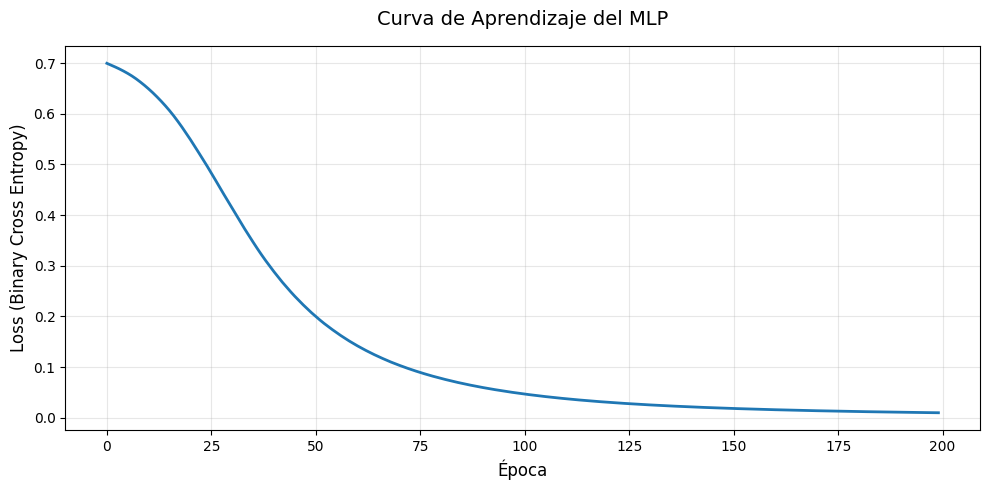

Interpretación de la curva:
- Curva descendente: El modelo está aprendiendo
- Convergencia: La pérdida se estabiliza en un valor bajo
- Si oscila mucho: Learning rate probablemente muy alto
- Si baja muy lento: Learning rate probablemente muy bajo

Esta curva muestra que el modelo convergió correctamente.


In [10]:
# Gráfico de la pérdida durante el entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(historial_loss, linewidth=2)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss (Binary Cross Entropy)', fontsize=12)
plt.title('Curva de Aprendizaje del MLP', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Interpretación de la curva:")
print("=" * 70)
print("- Curva descendente: El modelo está aprendiendo")
print("- Convergencia: La pérdida se estabiliza en un valor bajo")
print("- Si oscila mucho: Learning rate probablemente muy alto")
print("- Si baja muy lento: Learning rate probablemente muy bajo")
print("\nEsta curva muestra que el modelo convergió correctamente.")

---

## 11. Evaluación del Modelo

Evaluamos el modelo en el conjunto de entrenamiento (en un caso real usaríamos un conjunto de prueba separado).

In [11]:
# Ponemos el modelo en modo evaluación
# Esto desactiva Dropout y fija BatchNorm (no los usamos aquí, pero es buena práctica)
modelo.eval()

# torch.no_grad() desactiva el cálculo de gradientes (ahorra memoria y acelera)
with torch.no_grad():
    # Forward pass para obtener predicciones
    predicciones = modelo(X)

    # Convertimos probabilidades a clases (umbral 0.5)
    # predicciones >= 0.5 → clase 1, sino → clase 0
    clases_predichas = (predicciones >= 0.5).float()

# Calculamos accuracy
aciertos = (clases_predichas == y).sum().item()
total = len(y)
accuracy = aciertos / total

print("Evaluación en el conjunto de entrenamiento:")
print("=" * 70)

for i in range(len(frases)):
    prob = predicciones[i].item()
    pred_clase = clases_predichas[i].item()
    real_clase = y[i].item()

    correcto = "✓" if pred_clase == real_clase else "✗"
    sentimiento_real = "Positivo" if real_clase == 1 else "Negativo"
    sentimiento_pred = "Positivo" if pred_clase == 1 else "Negativo"

    print(f"\n{correcto} Frase: '{frases[i][:50]}...'")  # Truncamos si es muy larga
    print(f"  Real: {sentimiento_real} | Predicción: {sentimiento_pred} (prob={prob:.3f})")

print("\n" + "=" * 70)
print(f"Accuracy: {aciertos}/{total} = {accuracy:.2%}")

Evaluación en el conjunto de entrenamiento:

✓ Frase: 'La verdad, este lugar está bárbaro. Muy recomendab...'
  Real: Positivo | Predicción: Positivo (prob=0.989)

✓ Frase: 'Qué buena onda la atención, volvería sin dudarlo....'
  Real: Positivo | Predicción: Positivo (prob=0.997)

✓ Frase: 'Me encantó la comida, aunque la música estaba muy ...'
  Real: Positivo | Predicción: Positivo (prob=0.986)

✓ Frase: 'Todo excelente. Atención de diez....'
  Real: Positivo | Predicción: Positivo (prob=0.989)

✓ Frase: 'Muy conforme con el resultado final....'
  Real: Positivo | Predicción: Positivo (prob=0.988)

✓ Frase: 'Superó mis expectativas, gracias....'
  Real: Positivo | Predicción: Positivo (prob=0.990)

✓ Frase: 'El mejor asado que probé en mucho tiempo....'
  Real: Positivo | Predicción: Positivo (prob=0.986)

✓ Frase: 'Excelente relación precio-calidad, muy recomendabl...'
  Real: Positivo | Predicción: Positivo (prob=0.990)

✓ Frase: 'La atención fue impecable, muy atentos....'
  Real:

---

## 12. Predicción sobre Frases Nuevas

Probamos el modelo con frases que nunca vio durante el entrenamiento.

In [12]:
# Frases de prueba
frases_prueba = [
    "No me gustó la atención, bastante mala",
    "Muy buena experiencia, todo excelente",
    "Una estafa total, no lo recomiendo",
    "Súper conforme con el servicio",
    "Nada que ver con lo prometido, una decepción",
    "La mejor atención que tuve en mucho tiempo"
]

# Vectorizamos las frases nuevas
X_prueba_np = np.array([vectorizar(frase, vocabulario) for frase in frases_prueba], dtype=np.float32)
X_prueba = torch.tensor(X_prueba_np)

# Predicción en modo evaluación
modelo.eval()
with torch.no_grad():
    predicciones_prueba = modelo(X_prueba)

# Mostramos resultados
print("Predicciones sobre frases nuevas:")
print("=" * 70)

for i, frase in enumerate(frases_prueba):
    prob = predicciones_prueba[i].item()
    clase = "POSITIVO" if prob >= 0.5 else "NEGATIVO"
    confianza = prob if prob >= 0.5 else (1 - prob)

    print(f"\nFrase: '{frase}'")
    print(f"Predicción: {clase}")
    print(f"Probabilidad positivo: {prob:.3f}")
    print(f"Confianza: {confianza:.1%}")

Predicciones sobre frases nuevas:

Frase: 'No me gustó la atención, bastante mala'
Predicción: NEGATIVO
Probabilidad positivo: 0.000
Confianza: 100.0%

Frase: 'Muy buena experiencia, todo excelente'
Predicción: POSITIVO
Probabilidad positivo: 0.998
Confianza: 99.8%

Frase: 'Una estafa total, no lo recomiendo'
Predicción: NEGATIVO
Probabilidad positivo: 0.000
Confianza: 100.0%

Frase: 'Súper conforme con el servicio'
Predicción: POSITIVO
Probabilidad positivo: 0.986
Confianza: 98.6%

Frase: 'Nada que ver con lo prometido, una decepción'
Predicción: NEGATIVO
Probabilidad positivo: 0.030
Confianza: 97.0%

Frase: 'La mejor atención que tuve en mucho tiempo'
Predicción: POSITIVO
Probabilidad positivo: 0.998
Confianza: 99.8%


---

## 13. Comparación: Perceptrón Simple vs. MLP

Comparemos conceptualmente lo que ganamos con capas ocultas.

In [ ]:
print("COMPARACIÓN: PERCEPTRÓN SIMPLE VS. MLP")
print("=" * 70)

comparacion = [
    ("Arquitectura", "Una capa (entrada → salida)", "Múltiples capas (entrada → ocultas → salida)"),
    ("Parámetros", "~30 (30 pesos + 1 bias)", "~280 (30×8 + 8 + 8×1 + 1)"),
    ("Capacidad", "Solo problemas lineales", "Problemas no lineales complejos"),
    ("Función activación", "Escalón (no diferenciable)", "ReLU + Sigmoid (diferenciables)"),
    ("Aprendizaje", "Regla del perceptrón", "Backpropagation con Adam"),
    ("XOR", "❌ No puede resolverlo", "✓ Sí puede resolverlo"),
    ("Interacciones", "❌ No captura", "✓ Aprende features abstractas"),
    ("Convergencia", "Rápida si linealmente separable", "Más lenta pero más potente"),
    ("Overfitting", "Poco riesgo (modelo simple)", "Mayor riesgo (más parámetros)"),
    ("Interpretabilidad", "Alta (pesos directos)", "Media (representaciones ocultas)"),
]

print(f"\n{'Característica':<20} | {'Perceptrón Simple':<35} | {'MLP':<35}")
print("-" * 95)
for caracteristica, perceptron, mlp in comparacion:
    print(f"{caracteristica:<20} | {perceptron:<35} | {mlp:<35}")

print("\n" + "=" * 70)
print("Conclusión:")
print("-" * 70)
print("El MLP es más potente pero requiere:")
print("  1. Más datos para entrenar (evitar overfitting)")
print("  2. Más tiempo de cómputo")
print("  3. Ajuste de hiperparámetros (learning rate, hidden size, etc.)")
print("  4. Frameworks modernos (PyTorch, TensorFlow) para eficiencia")
print("\nEl perceptrón simple sigue siendo útil como baseline rápido.")

---

## 14. Guardar y Cargar el Modelo

En aplicaciones reales, necesitamos guardar modelos entrenados para usarlos más tarde.

In [ ]:
# Guardar el modelo
# state_dict() retorna un diccionario con todos los parámetros
torch.save(modelo.state_dict(), 'mlp_sentiment.pth')
print("Modelo guardado en: mlp_sentiment.pth")

# Cargar el modelo
# Primero creamos una instancia nueva del modelo
modelo_cargado = MLP(input_size, hidden_size)

# Luego cargamos los parámetros guardados
modelo_cargado.load_state_dict(torch.load('mlp_sentiment.pth'))
modelo_cargado.eval()  # Modo evaluación

print("Modelo cargado exitosamente.")

# Verificamos que funciona igual
with torch.no_grad():
    pred_original = modelo(X_prueba)
    pred_cargado = modelo_cargado(X_prueba)

    # Comprobamos que las predicciones son idénticas
    igual = torch.allclose(pred_original, pred_cargado)
    print(f"\n¿Predicciones idénticas? {igual}")

print("\nEn producción, guardarías el modelo después del entrenamiento")
print("y lo cargarías en un servidor/API para hacer predicciones.")

---

## Guía Teórico-Conceptual

### 1. Teorema de Aproximación Universal

**Enunciado (Cybenko, 1989; Hornik, 1991):**
> Una red neuronal feedforward con una sola capa oculta puede aproximar cualquier función continua en un dominio compacto, con precisión arbitraria, siempre que tenga suficientes neuronas ocultas.

**Implicaciones:**
- Los MLP son aproximadores universales de funciones
- En teoría, una capa oculta es suficiente
- En práctica, redes profundas (muchas capas) aprenden más eficientemente

**Limitaciones:**
- No dice cuántas neuronas se necesitan (podría ser exponencial)
- No garantiza que el entrenamiento encuentre la aproximación óptima
- Redes profundas suelen ser más eficientes que redes anchas

### 2. Backpropagation: La Magia de Autograd

Backpropagation es la aplicación de la regla de la cadena del cálculo:

$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial h} \cdot \frac{\partial h}{\partial w_1}$$

**En PyTorch:**
```python
loss.backward()  # Calcula TODOS los gradientes automáticamente
```

**Internamente:**
1. PyTorch registra todas las operaciones en un **grafo computacional**
2. Cuando llamamos `.backward()`, recorre el grafo en reversa
3. Aplica regla de la cadena en cada nodo
4. Acumula gradientes en `.grad` de cada tensor con `requires_grad=True`

**Ventaja sobre implementación manual:**
- No hay que derivar funciones a mano
- Funciona con arquitecturas arbitrariamente complejas
- Optimizado en C++/CUDA, muy rápido

### 3. ReLU vs. Sigmoid vs. Escalón

| Característica | Escalón | Sigmoid | ReLU |
|----------------|---------|---------|------|
| Fórmula | step(x) | 1/(1+e⁻ˣ) | max(0,x) |
| Rango | {0, 1} | (0, 1) | [0, ∞) |
| Diferenciable | ❌ No | ✓ Sí | ✓ Casi (excepto x=0) |
| Vanishing gradient | N/A | ✓ Problema | ❌ No sufre |
| Costo computacional | Bajo | Alto (exp) | Muy bajo |
| Uso moderno | Obsoleto | Solo salida | Capas ocultas |
| Dead neurons | No | No | Sí (si x<0 siempre) |

**¿Por qué ReLU domina en capas ocultas?**
- Gradiente constante para x>0 (no vanishing)
- Computacionalmente trivial (comparación)
- Introducida por Hinton et al. en 2010, revolucionó deep learning

**Variantes de ReLU:**
- **Leaky ReLU**: f(x) = max(0.01x, x) - evita dead neurons
- **ELU**: Suave en x<0
- **GELU**: Usada en transformers (BERT, GPT)

### 4. Vanishing Gradient Problem

**Problema:**
En redes profundas con sigmoides, los gradientes se multiplican capa por capa:

$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial h_n} \cdot \sigma'(h_{n-1}) \cdot ... \cdot \sigma'(h_2) \cdot \sigma'(h_1)$$

Como $\sigma'(x) \in (0, 0.25)$, el producto de muchos términos < 0.25 tiende a cero.

**Consecuencias:**
- Capas iniciales no aprenden (gradientes ~0)
- Solo capas finales se entrenan
- Redes profundas imposibles antes de 2010

**Soluciones:**
1. **ReLU**: Gradiente = 1 para x>0
2. **Batch Normalization**: Normaliza activaciones
3. **Residual connections**: Skip connections (ResNet)
4. **Inicialización cuidadosa**: Xavier, He initialization

### 5. Overfitting en Redes Neuronales

**Síntomas:**
- Training loss baja pero validation loss sube
- Accuracy muy alta en train, baja en test
- El modelo memoriza en vez de generalizar

**Causas:**
1. Demasiados parámetros vs. datos
2. Entrenamiento muy largo
3. Falta de regularización

**Soluciones:**

**Regularización L2 (weight decay):**
```python
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
```

**Dropout:**
```python
nn.Dropout(p=0.5)  # Desactiva 50% de neuronas aleatoriamente
```

**Early stopping:**
```python
if val_loss > best_val_loss:
    epochs_without_improvement += 1
    if epochs_without_improvement > patience:
        break  # Detener entrenamiento
```

**Data augmentation:**
- Sinónimos, paráfrasis, traducciones

### 6. Hiperparámetros: Tuning Strategies

**Principales hiperparámetros:**
1. **Learning rate**: Más importante, probar [1e-5, 1e-1]
2. **Hidden size**: Capacidad del modelo
3. **Número de capas**: Profundidad
4. **Batch size**: Velocidad vs. convergencia
5. **Optimizer**: Adam suele ser la mejor opción

**Estrategias de búsqueda:**

**Grid search:**
```python
for lr in [0.001, 0.01, 0.1]:
    for hidden in [8, 16, 32]:
        train_and_evaluate(lr, hidden)
```

**Random search:** Más eficiente que grid

**Bayesian optimization:** Aún más eficiente

**Learning rate scheduling:**
```python
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
```

### 7. Batch Training vs. Online Learning

En este notebook entrenamos con **full batch** (todo el dataset a la vez).

**Alternativas:**

**Stochastic Gradient Descent (SGD):**
- Una muestra a la vez
- Muy ruidoso pero escapa mínimos locales

**Mini-batch:**
- Típicamente 32-256 muestras
- Balance entre velocidad y estabilidad
- Estándar en deep learning

**Implementación:**
```python
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for X_batch, y_batch in dataloader:
    # Entrenar con el batch
```

---

## Preguntas y Respuestas para Estudio

### Preguntas Conceptuales

**1. ¿Por qué una red multicapa puede resolver XOR y el perceptrón simple no?**

*Respuesta:* La capa oculta proyecta los datos a un espacio de mayor dimensión donde SÍ son linealmente separables. Por ejemplo, XOR en 2D no es separable, pero si la capa oculta aprende las features h₁=(x₁ AND x₂) y h₂=(x₁ OR x₂), entonces en el espacio (h₁, h₂) SÍ es separable. La capa oculta aprende representaciones útiles automáticamente.

**2. ¿Qué es autograd y cómo funciona en PyTorch?**

*Respuesta:* Autograd (automatic differentiation) es el sistema de PyTorch que calcula gradientes automáticamente. Registra todas las operaciones en un grafo computacional y, cuando llamamos `loss.backward()`, recorre el grafo en reversa aplicando la regla de la cadena. Esto nos libera de derivar funciones manualmente.

**3. ¿Por qué usamos ReLU en capas ocultas y Sigmoid en la salida?**

*Respuesta:*
- **ReLU en ocultas**: No sufre vanishing gradient, es computacionalmente eficiente y permite entrenar redes profundas
- **Sigmoid en salida**: Convierte la salida a rango [0,1] interpretable como probabilidad, compatible con Binary Cross Entropy Loss

**4. ¿Qué significa "requires_grad=True" en un tensor?**

*Respuesta:* Indica que PyTorch debe calcular y almacenar gradientes para ese tensor. Los parámetros del modelo (pesos, biases) tienen `requires_grad=True` por defecto. Los datos de entrada no, porque no los vamos a optimizar.

**5. ¿Por qué llamamos `optimizer.zero_grad()` antes de cada backward pass?**

*Respuesta:* Porque PyTorch **acumula** gradientes por defecto (suma los nuevos a los existentes). Si no limpiamos, estaríamos acumulando gradientes de múltiples batches, lo cual es incorrecto. En algunos casos avanzados (gradient accumulation) esta acumulación es intencional, pero normalmente queremos empezar de cero.

### Preguntas Técnicas

**6. ¿Cuál es la diferencia entre `model.train()` y `model.eval()`?**

*Respuesta:*
- `model.train()`: Activa modo entrenamiento. Dropout hace drop, BatchNorm actualiza estadísticas
- `model.eval()`: Activa modo evaluación. Dropout no hace drop, BatchNorm usa estadísticas fijas

Aunque nuestro MLP no usa estas capas, es buena práctica llamarlos para compatibilidad.

**7. ¿Qué hace `torch.no_grad()` y cuándo usarlo?**

*Respuesta:* Desactiva el tracking de gradientes. Útil durante evaluación/inferencia para:
1. Ahorrar memoria (no construir grafo computacional)
2. Acelerar ejecución
3. Prevenir errores (actualizar parámetros accidentalmente)

**8. En el código, ¿por qué reshape(-1, 1) en las etiquetas?**

*Respuesta:* `BCELoss` espera que predicciones y etiquetas tengan la misma forma. Nuestro modelo devuelve shape `(n, 1)`, así que las etiquetas también deben ser `(n, 1)` en vez de `(n,)`. El `-1` en reshape significa "inferir esta dimensión automáticamente".

**9. ¿Qué es un "forward pass" y un "backward pass"?**

*Respuesta:*
- **Forward pass**: Los datos fluyen de entrada a salida, calculando predicciones: `y_pred = model(X)`
- **Backward pass**: Los gradientes fluyen de salida a entrada, calculando ∂Loss/∂params: `loss.backward()`

**10. ¿Por qué `.item()` en `loss.item()`?**

*Respuesta:* `.item()` extrae el valor numérico de un tensor de un solo elemento y lo convierte a tipo Python (float). Sin `.item()`, tendríamos un tensor, que consume memoria del grafo computacional. Es buena práctica para logging.

### Preguntas de Aplicación

**11. Si la curva de loss oscila mucho sin bajar, ¿qué harías?**

*Respuesta:*
1. **Reducir learning rate**: Probar 0.001 en vez de 0.01
2. **Cambiar optimizador**: Adam → SGD with momentum
3. **Normalizar datos**: Estandarizar features
4. **Revisar implementación**: ¿Está llamando zero_grad()?
5. **Aumentar batch size**: Más estabilidad (si usás mini-batches)

**12. ¿Cómo adaptarías este código para clasificación multiclase (3+ clases)?**

*Respuesta:*
```python
# 1. Cambiar salida del modelo
nn.Linear(hidden_size, num_classes),  # En vez de 1
nn.Softmax(dim=1)  # En vez de Sigmoid

# 2. Cambiar loss
criterio = nn.CrossEntropyLoss()  # En vez de BCELoss

# 3. Etiquetas como enteros
y = torch.tensor([0, 1, 2, 0, 1, ...])  # Sin one-hot

# 4. Predicción
pred_class = torch.argmax(output, dim=1)  # Clase con mayor prob
```

**13. Si tuvieras 10,000 frases en vez de 20, ¿qué cambios harías al código?**

*Respuesta:*
1. **Usar DataLoader** para mini-batches (batch_size=32 o 64)
2. **Split train/test**: 80/20 para evaluación honesta
3. **Más épocas**: Probablemente 50-200 en vez de 200 sobre dataset pequeño
4. **Red más grande**: hidden_size=64 o 128
5. **Agregar Dropout**: Para prevenir overfitting
6. **Usar GPU**: `model.to('cuda')` para acelerar

**14. ¿Cómo implementarías early stopping?**

*Respuesta:*
```python
best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

for epoca in range(max_epocas):
    # Entrenar...
    val_loss = evaluar_en_validacion()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print("Early stopping")
        break
```

**15. Explicá cómo desplegarías este modelo en una API REST.**

*Respuesta:*
```python
from fastapi import FastAPI
import torch

app = FastAPI()

# Cargar modelo al inicio
modelo = MLP(input_size=30, hidden_size=8)
modelo.load_state_dict(torch.load('mlp_sentiment.pth'))
modelo.eval()

@app.post("/predict")
def predict(texto: str):
    # Vectorizar
    x = torch.tensor(vectorizar(texto, vocabulario))
    
    # Predecir
    with torch.no_grad():
        prob = modelo(x.unsqueeze(0)).item()
    
    return {
        "texto": texto,
        "sentimiento": "positivo" if prob > 0.5 else "negativo",
        "probabilidad": prob
    }
```

---

## Ejercicios Propuestos

### Ejercicio 1: Experimentación con Arquitecturas
Probá diferentes configuraciones:
- hidden_size: 4, 8, 16, 32, 64
- Dos capas ocultas: Input → 16 → 8 → Output

Graficá las curvas de loss. ¿Más neuronas siempre es mejor?

### Ejercicio 2: Funciones de Activación
Reemplazá ReLU por otras activaciones:
- `nn.Tanh()`
- `nn.LeakyReLU()`
- `nn.ELU()`

Compará convergencia y accuracy final.

### Ejercicio 3: Regularización con Dropout
Agregá dropout después de la capa oculta:
```python
self.net = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # ← Nuevo
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)
```
¿Cómo afecta al entrenamiento?

### Ejercicio 4: Optimizadores
Compará Adam vs. SGD:
```python
optimizer_sgd = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
```
¿Cuál converge más rápido?

### Ejercicio 5: Problema XOR
Entrená el MLP con el problema XOR:
```python
X_xor = torch.tensor([[0.,0.], [0.,1.], [1.,0.], [1.,1.]])
y_xor = torch.tensor([[0.], [1.], [1.], [0.]])
```
Verificá que converge. Probá con hidden_size=2, 4, 8. ¿Cuál es el mínimo?

---

## Conclusión

En este notebook dimos un salto fundamental: de implementación manual a framework moderno, y de modelos lineales a redes multicapa. Aprendimos:

1. **Fundamentos de PyTorch**: Tensores, autograd, nn.Module
2. **Arquitectura MLP**: Capas ocultas, ReLU, Sigmoid
3. **Entrenamiento con backpropagation**: Forward, loss, backward, step
4. **Superación de limitaciones**: XOR y problemas no lineales
5. **Prácticas profesionales**: Guardar/cargar modelos, modo train/eval

### ¿Qué sigue?

Las redes feedforward (MLP) ignoran el **orden** de las palabras. En el próximo notebook vamos a usar **LSTM (Long Short-Term Memory)**, una arquitectura recurrente que procesa texto como secuencia, capturando contexto y dependencias temporales.

Con LSTM podremos modelar patrones como:
- "No me gustó" vs. "Me gustó" (negación)
- "Muy muy bueno" (énfasis por repetición)
- Dependencias largas en el texto

---

*Este material fue desarrollado con fines educativos para la Tecnicatura en Ciencia de Datos del IFTS.*